# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [6]:
np.shape(next_states)

(2, 24)

In [7]:
np.shape(actions)

(2, 2)

In [8]:
rewards

[0.0, -0.009999999776482582]

In [9]:
dones

[True, True]

When finished, you can close the environment.

In [10]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [11]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import copy

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class ActorNetwork(nn.Module):
    """Actor Model."""

    def __init__(self, state_size, action_size, seed, fc1_dims = 256, fc2_dims = 128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_dims (int): Number of nodes in first hidden layer
            fc2_dims (int): Number of nodes in second hidden layer

        """
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.bn1 = nn.BatchNorm1d(fc1_dims)
        self.bn2 = nn.BatchNorm1d(fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, action_size)        
         
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
            
        x =  F.relu(self.fc1(state))
        x =  self.bn1(x)
        
        x =  F.elu(self.fc2(x))
        x =  self.bn2(x)
        return F.tanh(self.fc3(x))
    
    
    
class CriticNetwork(nn.Module):
    """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

    def __init__(self, state_size, action_size, seed, fc1_dims = 256, fc2_dims = 128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_dims (int): Number of nodes in first hidden layer
            fc2_dims (int): Number of nodes in second hidden layer

        """
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dims)
        self.bn1 = nn.BatchNorm1d(fc1_dims)
        self.fc2 = nn.Linear(action_size + fc1_dims, 2*fc2_dims)
        self.fc3  = nn.Linear(2*fc2_dims , fc2_dims)  
        self.fc4 =  nn.Linear(fc2_dims , 1)
              
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a network that maps state -> action values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
            
        state_value = F.relu(self.fc1(state))
        state_value = self.bn1(state_value)
       
        state_action_value = torch.cat((state_value, action), dim=1)
        state_action_value = F.elu(self.fc2(state_action_value))
        state_action_value = F.elu(self.fc3(state_action_value))
        
        return self.fc4(state_action_value)

In [13]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, config, random_seed = 0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = config["buffer_size"]
        self.batch_size  = config["batch_size"]
        self.tau = config["tau"]
        self.gamma = config["gamma"]
        self.lr_critic = config["lr_critic"]
        self.lr_actor = config["lr_actor"]
        self.update   =  config["update"]
        self.t_step = 0  
        self.scale = config["scale"]
        self.scale_decay = config["scale_decay"]
        self.scale_end = config["scale_end"]
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size,self.batch_size, random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local  = ActorNetwork(state_size, action_size, random_seed)
        self.actor_target = ActorNetwork(state_size, action_size, random_seed)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = self.lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local_1 = CriticNetwork(state_size, action_size, random_seed)
        self.critic_local_2 = CriticNetwork(state_size, action_size, random_seed)
        
        self.critic_target_1 = CriticNetwork(state_size, action_size, random_seed)
        self.critic_target_2 = CriticNetwork(state_size, action_size, random_seed)
        
        self.critic_optimizer_1 = optim.Adam(self.critic_local_1.parameters(), lr = self.lr_critic)
        self.critic_optimizer_2 = optim.Adam(self.critic_local_2.parameters(), lr = self.lr_critic)
        
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn, if enough samples are available in memory        
        self.t_step = (self.t_step + 1) % self.update
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            for _ in range(16):
                if len(self.memory) > self.batch_size:
                    experiences = self.memory.sample()
                    self.learn(experiences)

    def choose_action(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.actor_local.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.scale * self.noise.sample()
        return np.clip(action, -1, 1)
    
    
    
    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        states  = torch.tensor(states, dtype = torch.float).to(self.actor_local.device)
        rewards = torch.tensor(rewards,dtype = torch.float ).to(self.actor_local.device)
        dones   = torch.tensor(dones,  dtype = torch.float).to(self.actor_local.device)
        actions = torch.tensor(actions, dtype = torch.float).to(self.actor_local.device)
        next_states = torch.tensor(next_states, dtype = torch.float).to(self.actor_local.device)

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        
        target_actions = self.actor_target.forward(next_states)
        target_actions = target_actions + \
                        torch.clamp(torch.tensor(np.random.normal(scale=0.2)).to(device), -0.5, 0.5)

        q1_ = self.critic_target_1.forward(next_states, target_actions)
        q2_ = self.critic_target_2.forward(next_states, target_actions)


        q1   = self.critic_local_1.forward(states, actions)
        q2   = self.critic_local_2.forward(states, actions)
        
        critic_value_ = torch.min(q1_, q2_)

        target = rewards + (self.gamma * critic_value_* (1-dones))       
   

        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()

        q1_loss  = F.mse_loss(target, q1)
        q2_loss  = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss

        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local_1.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(self.critic_local_2.parameters(), 1.0)
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        self.actor_optimizer.zero_grad()
        actions_pred = self.actor_local.forward(states)
        actor_loss = - self.critic_local_1.forward(states, actions_pred)
        actor_loss = torch.mean(actor_loss)
        # Minimize the loss

        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1.0)
        self.actor_optimizer.step()



        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local_1, self.critic_target_1)
        self.soft_update(self.critic_local_2, self.critic_target_2)
        self.soft_update(self.actor_local, self.actor_target) 
        self.scale -= self.scale_decay
        self.scale = max(self.scale, self.scale_end)
        self.noise.reset()

        
    def reset(self):
        self.noise.reset()
    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.standard_normal(size=x.shape))
        self.state = x + dx
        return self.state

In [15]:
def plot_learning_curve(x, scores, figure_file):
     
    running_avg = np.empty(len(scores))
    
    for t in range(len(scores)):
        running_avg [t] = np.mean(scores[max(0, t-10):(t+1)])        
        
    plt.plot(x, running_avg)
    plt.title("running avg of previous 10 scores")
    plt.savefig(figure_file)

Episode 20	Average Score: 0.01	 score_max: 0.10
Episode 40	Average Score: 0.01	 score_max: 0.10
Episode 60	Average Score: 0.00	 score_max: 0.10
Episode 80	Average Score: 0.00	 score_max: 0.10
Episode 100	Average Score: 0.00	 score_max: 0.10
Episode 120	Average Score: 0.00	 score_max: 0.10
Episode 140	Average Score: 0.00	 score_max: 0.10
Episode 160	Average Score: 0.00	 score_max: 0.10
Episode 180	Average Score: 0.00	 score_max: 0.10
Episode 200	Average Score: 0.00	 score_max: 0.10
Episode 220	Average Score: 0.00	 score_max: 0.10
Episode 240	Average Score: 0.00	 score_max: 0.10
Episode 260	Average Score: 0.00	 score_max: 0.10
Episode 280	Average Score: 0.00	 score_max: 0.10
Episode 300	Average Score: 0.00	 score_max: 0.10
Episode 320	Average Score: 0.01	 score_max: 0.10
Episode 340	Average Score: 0.01	 score_max: 0.10
Episode 360	Average Score: 0.01	 score_max: 0.10
Episode 380	Average Score: 0.02	 score_max: 0.10
Episode 400	Average Score: 0.02	 score_max: 0.20
Episode 420	Average Scor

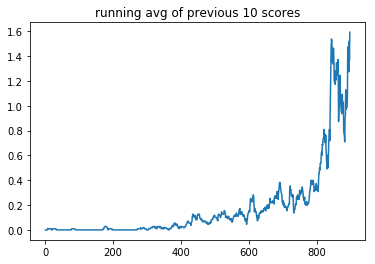

In [16]:
config = {"buffer_size": 1000000,  # replay buffer size
          "batch_size" : 128,        # minibatch size
          "gamma" : 0.99,            # discount factor
          "tau" : 1e-3,              # for soft update of target parameters
          "lr_actor" : 4e-4,         # learning rate of the actor 
          "lr_critic": 4e-4,         # learning rate of the critic
          "update": 4,               # Update times of critic/actor in each trajectory
          "scale" : 5,               # initial scale of noise
          "scale_decay": 1e-4,       # scale decay
          "scale_end": 0
             }
n_games = 1000  # number of episodes

scores, eps_history = [], []

state_size = 48
action_size= 4

agent = Agent(state_size, action_size, config, random_seed=23142)
best_scores = 0
scores_deque = deque(maxlen= 100)

for i in range(1, n_games+1):
    env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
    state = env_info.vector_observations
    state = np.reshape(state, (48,))
    score = 0
    done = False
    
    #reset noise
    agent.reset()
    
    while not done:
        action = agent.choose_action(state)

        # Reshape action to the right shape used in env
        action = np.reshape(action, (2,2))

        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations   # get the next state
        reward = env_info.rewards                   # get the reward
        done = env_info.local_done[0]

        # Reshape next_state and action to the right shape used in agent
        next_state = np.reshape(next_state, (48,))
        action = np.reshape(action, (4,))

        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += np.max(reward)
        
        if done:
            break

    scores.append(score)              # save most recent score
    scores_deque.append(score)   
    avg_score = np.mean(scores_deque)
    max_score = np.max(scores_deque)
    min_score = np.min(scores_deque)
    print('\rEpisode {}\tAverage Score: {:.2f}\t score_max: {:.2f}'.format(i, avg_score, max_score), end="")
    
    if avg_score > best_scores:
        best_scores = avg_score
        # Save model
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local_1.state_dict(), 'checkpoint_critic_1.pth')
        torch.save(agent.critic_local_2.state_dict(), 'checkpoint_critic_2.pth')

    if i % 20 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, avg_score))

    if avg_score >= 1.0:
        break
        
        
x = [i+1 for i in range(len(scores))]
plot_learning_curve(x, scores, figure_file = "fig.png") 